This notebook has been abstracted from work done elsewhere to provide a clean workflow for producing a summary table. This notebook is particularly useful for querying the SIMBAD database for specific data of interest for a list of Kepler objects.

In [5]:
import pickle

In [8]:
with open('scores/Average','rb') as f:
    avscores = pickle.load(f).set_index('KIC')


In [1]:
from astroquery.simbad import Simbad

In [2]:
Simbad.reset_votable_fields()
Simbad.remove_votable_fields('main_id')
Simbad.add_votable_fields('typed_id')
Simbad.remove_votable_fields('coordinates')
Simbad.add_votable_fields('otype')
Simbad.add_votable_fields('coo')
Simbad.add_votable_fields('biblio')

In [3]:
from astropy.table import Table,vstack

In [9]:
nchunks = int(len(avscores)/1000)
chunks = [range(i*1000,i*1000+1000) for i in range(nchunks)]
lastchunk = range(nchunks*1000,nchunks*1000+len(avscores)%1000)
chunks.append(lastchunk)

Output for follwoing block is suppressed, nonfatal errors are produced for every object that isn't in SIMBAD. Otherwise, the connection is occasionally reset, in which case it tries again until the connection is reestablished. The chunk size should prevent this from overwhelming the server and it *shouldn't* result in being temporarily blacklisted for submitting too many queries at once... Use at own risk.

In [ ]:
def simbadquery(avscores,chunk,result_table):
    try:
        chunktable = Simbad.query_objects(['KIC{}'.format(i) for i in avscores.index[chunk]])
        chunktable.remove_columns(['COO_ERR_MAJA','COO_ERR_MINA','COO_ERR_ANGLE'])
        result_table = vstack([result_table,chunktable])
    except ConnectionError:
        simbadquery(avscores,chunk,result_table)
        
    return result_table

result_table = Simbad.query_objects(['KIC{}'.format(i) for i in avscores.index[chunks[0]]])
for chunk in chunks[72:]:
    result_table = simbadquery(avscores,chunk,result_table)

        

In [112]:
simbad_summary_df = result_table.to_pandas().set_index(avscores.index).drop(columns='TYPED_ID')

In [151]:
simbad_summary_df['OTYPE']=simbad_summary_df.loc[:,'OTYPE'].apply(lambda x:x.decode())
simbad_summary_df['BIBLIO']=simbad_summary_df.loc[:,'BIBLIO'].apply(lambda x:x.decode())

In [152]:
simbad_summary_df

,OTYPE,RA,DEC,BIBLIO
KIC,,,,
757076,Star,19 24 09.2898,+36 35 53.121,2017ApJS..229...30M
757099,Cepheid,19 24 10.3300,+36 35 37.602,2019MNRAS.484..834G|2016ApJ...829...23D|2014Ap...
757137,Eruptive*,19 24 13.4198,+36 33 35.724,2018ApJS..236...42Y|2016ApJ...829...23D
757280,,,,
757450,RotV*,19 24 33.0185,+36 34 38.477,2019AJ....158...59S|2019MNRAS.482.1379H|2019MN...
...,...,...,...,...
100004295,,,,
100004297,,,,
100004298,,,,


In [13]:
summary_df = pd.DataFrame(index=avscores.index)

In [14]:
summary_df['median_rank']=avscores.rank(ascending=False).median(axis=1)

In [15]:
summary_df['most_outlying_rank']=avscores.rank(ascending=False).min(axis=1)

In [1]:
from multiprocessing import Pool,cpu_count
import pickle
import pandas as pd

In [2]:
with open('scores/Average','rb') as f:
    avscores = pickle.load(f).set_index('KIC')

In [3]:
def minq(kic):
    minloc = av_scores.rank(ascending=False).loc[kic]==av_scores.rank(ascending=False).min(axis=1).loc[kic]
    min_q = av_scores.loc[kic,minloc].index[0]
    return min_q
global av_scores #Pool.map can only take one variable... so I have to pass avscores as a global
av_scores=avscores

In [6]:
useCpus = cpu_count()
p = Pool(useCpus)
min_q = p.map(minq,av_scores.index)
p.close()
p.join()

In [16]:
summary_df['most_outlying_quarter']=min_q

In [14]:
len(result_table)

201266

In [154]:
full_summary_df = pd.concat([summary_df,simbad_summary_df],axis=1)

In [156]:
full_summary_df.head()

,median_rank,most_outlying_rank,most_outlying_quarter,OTYPE,RA,DEC,BIBLIO
KIC,,,,,,,
757076,38099.0,8427.0,Q14,Star,19 24 09.2898,+36 35 53.121,2017ApJS..229...30M
757099,2530.0,1563.0,Q2,Cepheid,19 24 10.3300,+36 35 37.602,2019MNRAS.484..834G|2016ApJ...829...23D|2014Ap...
757137,36285.0,13696.0,Q11,Eruptive*,19 24 13.4198,+36 33 35.724,2018ApJS..236...42Y|2016ApJ...829...23D
757280,39413.0,8991.0,Q10,,,,
757450,4610.0,2650.0,Q7,RotV*,19 24 33.0185,+36 34 38.477,2019AJ....158...59S|2019MNRAS.482.1379H|2019MN...


In [155]:
full_summary_df.to_csv('KIC_Summary.csv')

In [1]:
import pandas as pd

In [2]:
summary_df = pd.read_csv('filesforpaper/KIC_Summary.csv',index_col='KIC')

In [3]:
summary_df.loc[3542116,:]

median_rank                                                          25205
most_outlying_rank                                                    3535
most_outlying_quarter                                                  Q10
OTYPE                                                                 Star
RA                                                           19 22 52.9409
DEC                                                          +38 41 41.487
BIBLIO                   2019A&A...625L..13Z|2019MNRAS.482.5587K|2019MN...
Name: 3542116, dtype: object

In [8]:
%matplotlib inline

In [5]:
from lightkurve import search_lightcurvefile

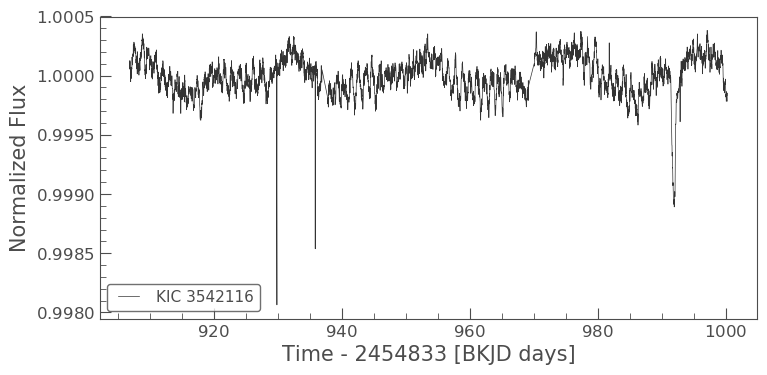

In [9]:
lcf = search_lightcurvefile('3542116', mission="Kepler", quarter=10).download()
# use the normalized PDCSAP flux 
nlc = lcf.PDCSAP_FLUX.normalize()
nlc.plot()

In [10]:
summary_df.loc[11084727,:]

median_rank                                                          30014
most_outlying_rank                                                    3187
most_outlying_quarter                                                  Q11
OTYPE                                                                 Star
RA                                                           19 28 41.1976
DEC                                                          +48 41 15.133
BIBLIO                   2019A&A...625L..13Z|2019MNRAS.482.5587K|2019MN...
Name: 11084727, dtype: object

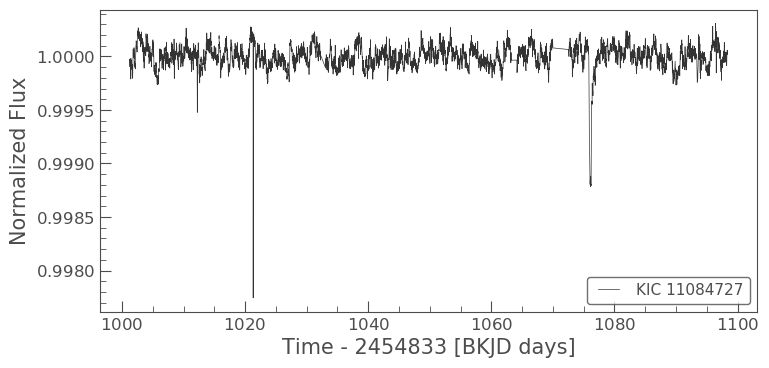

In [11]:
lcf = search_lightcurvefile('11084727', mission="Kepler", quarter=11).download()
# use the normalized PDCSAP flux 
nlc = lcf.PDCSAP_FLUX.normalize()
nlc.plot()

In [12]:
summary_df.loc[8027456,:]

median_rank                                                          30209
most_outlying_rank                                                    9172
most_outlying_quarter                                                  Q15
OTYPE                                                         PulsV*delSct
RA                                                           19 25 15.8332
DEC                                                          +43 51 33.565
BIBLIO                   2019A&A...625L..13Z|2019MNRAS.482.5587K|2016A&...
Name: 8027456, dtype: object

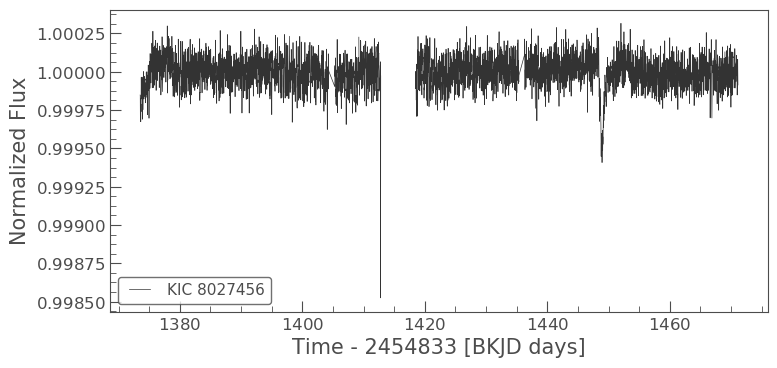

In [19]:
lcf = search_lightcurvefile('8027456', mission="Kepler", quarter=15).download()
# use the normalized PDCSAP flux 
nlc = lcf.PDCSAP_FLUX.normalize()
nlc.plot()

In [14]:
from astropy.io import ascii

In [15]:
table = ascii.read("filesforpaper/outlier_scores.txt")

In [16]:
scores_df = table[1:].to_pandas()

In [17]:
scores_df = scores_df.astype({'KIC':int}).set_index('KIC')

In [18]:
scores_df.rank(ascending=False).loc[[3542116,11084727,8027456],:]

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
KIC,,,,,,,,,,,,,,,,,
3542116,11683.0,9782.0,25205.0,54103.0,33993.0,42634.0,21794.0,9018.0,35203.0,3535.0,14364.0,5745.0,6683.0,41250.0,40695.0,38032.0,54057.0
11084727,26863.0,29451.0,58879.0,43718.0,24289.0,45000.0,23070.0,26279.0,35980.0,22139.0,3187.0,30014.0,14433.0,51665.0,39669.0,43007.0,66837.0
8027456,23928.0,NaN,36636.0,NaN,38646.0,NaN,30209.0,NaN,37894.0,10793.0,20835.0,NaN,38641.0,25313.0,9172.0,NaN,37617.0


In [69]:
table = ascii.read("filesforpaper/outlier_scores_alt.txt")
scores_alt_df = table[1:].to_pandas()
scores_alt_df = scores_alt_df.astype({'KIC':int}).set_index('KIC')

In [95]:
len(scores_df.Q8.dropna())

167783

In [27]:
import matplotlib.pyplot as plt

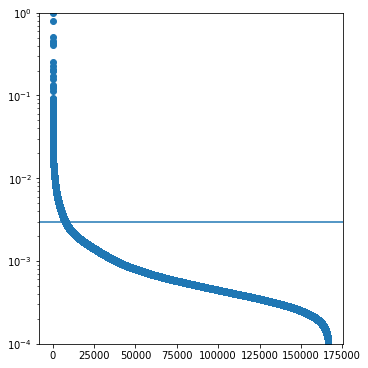

In [93]:
fig,ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
ax.scatter(scores_df['Q10'].sort_values(ascending=False).rank(ascending=False),scores_df['Q10'].sort_values(ascending=False))
ax.set_yscale('log')
ax.set_ylim(1E-4,1E0)
ax.axhline(3E-3)
plt.show()

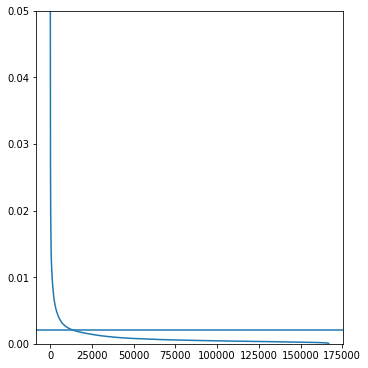

In [97]:
fig,ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
ax.plot(scores_df['Q10'].sort_values(ascending=False).rank(ascending=False),scores_df['Q10'].sort_values(ascending=False))
ax.set_ylim(0,.05)
ax.axhline(2E-3)
plt.show()

In [50]:
Qs = ['Q{}'.format(i) for i in range(1,18)]

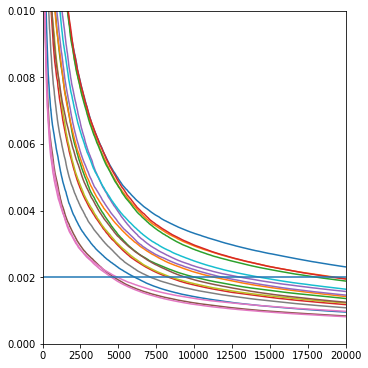

In [60]:
fig,ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
for Q in Qs:
    ax.plot(scores_df[Q].sort_values(ascending=False).rank(ascending=False),scores_df[Q].sort_values(ascending=False))
ax.set_ylim(0,.01)
ax.set_xlim(0,20000)
ax.axhline(2E-3)
plt.show()

In [62]:
for Q in Qs:
    print(Q,len(scores_df[Q][scores_df[Q]>2E-3]),len(scores_df[Q].dropna()))

Q1 25089 156126
Q2 19316 166279
Q3 10047 165531
Q4 8308 169817
Q5 13054 166268
Q6 4710 165283
Q7 4543 163305
Q8 7112 167783
Q9 8496 167243
Q10 14328 166897
Q11 6079 164065
Q12 11327 166867
Q13 18092 166631
Q14 19106 166910
Q15 11884 164737
Q16 9412 167508
Q17 4936 167575


In [64]:
for Q in Qs:
    print(Q,5000/len(scores_df[Q].dropna()))

Q1 0.03202541536963734
Q2 0.03006994268668924
Q3 0.030205822474340154
Q4 0.029443459724291444
Q5 0.030071932061491086
Q6 0.030251145005838472
Q7 0.030617556106671565
Q8 0.029800396941287256
Q9 0.029896617496696424
Q10 0.029958597218643836
Q11 0.030475726084173954
Q12 0.029963983292082916
Q13 0.030006421374174072
Q14 0.02995626385477203
Q15 0.030351408608873538
Q16 0.029849320629462474
Q17 0.02983738624496494


In [68]:
tb = scores_df.rank(ascending=False).loc[[8462852],:]

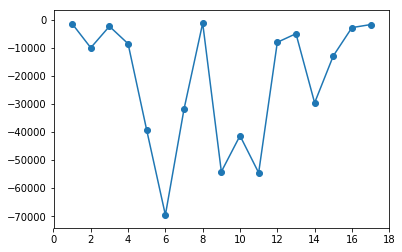

In [73]:
plt.plot(range(1,18),-tb.T)
plt.scatter(range(1,18),-tb.T)

In [74]:
tb

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
KIC,,,,,,,,,,,,,,,,,
8462852,1443.0,10032.0,2395.0,8592.0,39407.0,69587.0,31841.0,1266.0,54163.0,41358.0,54546.0,8086.0,5018.0,29639.0,12935.0,2849.0,1774.0


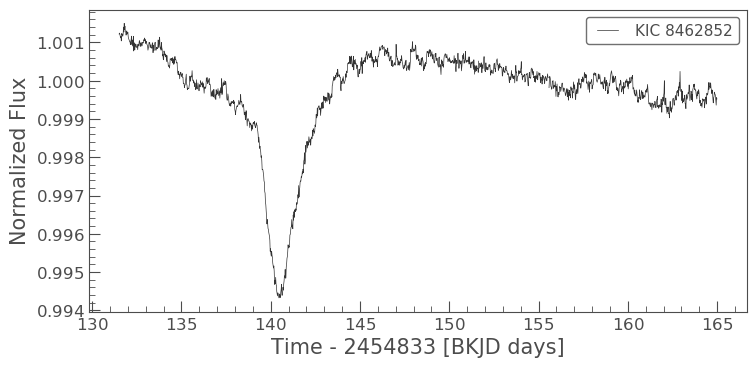

In [92]:
lcf = search_lightcurvefile('8462852', mission="Kepler", quarter=1).download()
nlc = lcf.PDCSAP_FLUX.normalize()
nlc.plot()